# [Task 1] Named Entity Recognition  |  LSTM  |  PyTorch

Import Libraries.

In [1]:
import re
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
from collections import Counter
from pandas.io.json import json_normalize

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

from sklearn_crfsuite import metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
%matplotlib inline
sns.set_style("dark")

## Util

Function to read json files.

In [3]:
def read_json(path):
    file = json.loads(open(path).read())
    
    return file

Function to extract words from text based on the indices.

In [4]:
def extract_word(begin, end, txt):
    return txt[begin:end]

In [5]:
base_dir = "../../data/AGAC_training-annotations/AGAC_training/json/"

## Prepare Data

BIO labelling of data.  

In [6]:
word_label_dict = {}

    
for f in os.listdir(base_dir):
    file = read_json(base_dir + f)
    # Extract the document ID from the file name
    doc_id = "".join(re.findall(r'\d', f))
    txt = file['text']


    for i in range(len(file['denotations'])):
        b = file['denotations'][i]['span']['begin']
        e = file['denotations'][i]['span']['end']
        word = extract_word(b, e, txt)
        word_split = word.split(' ')
        obj = file['denotations'][i]['obj']

        # If length of word (after splitting on " ") is more than 2
        # Put 'B/I' labels
        if len(word_split) == 2:
            b_word = word_split[0]
            i_word = word_split[-1]
            b_obj = "B-" + obj
            i_obj = "I-" + obj
            word_label_dict[i_word] = i_obj
            word_label_dict[b_word] = b_obj

        # If length of word (after splitting on " ") is equal to 1
        # Put a 'B' label
        else:
            b_word = word_split[0]
            b_obj = "B-" + obj

            word_label_dict[b_word] = b_obj

Clean the data and put the label 'O' where necessary.

In [7]:
final_list = []

for f in os.listdir(base_dir):
    file = read_json(base_dir + f)
    doc_id = "".join(re.findall(r'\d', f))
    txt = file['text']

    # Clean the text data
    txt = re.sub(r'\n', " ", txt)
    txt = re.sub(r'\.', "", txt)
    txt = re.sub(r',', "", txt)
    txt = re.sub(r':', "", txt)


    txt_split = txt.split(" ")

    # Put a label 'O' for words that do not appear
    # in word_label_dict
    for w in txt_split:
        if w in word_label_dict.keys():
            final_list.append((doc_id, w, word_label_dict[w]))
        else:
            final_list.append((doc_id, w, "O"))

In [8]:
data_df = pd.DataFrame(final_list, columns=['doc_id', 'word', 'obj'])

In [9]:
data_df.head()

,doc_id,word,obj
0,30442766,LZTR1,B-Gene
1,30442766,is,O
2,30442766,a,O
3,30442766,regulator,O
4,30442766,of,O


## EDA

### Count of words/obj per document.

In [10]:
data_df.groupby('doc_id').count().head()

,word,obj
doc_id,,
16371368,307,307
17435236,229,229
18031991,235,235
18594199,189,189
19338054,265,265


### Stats about the data.

In [11]:
data_df.describe()

,doc_id,word,obj
count,55808,55808,55808
unique,250,9744,25
top,28283687,of,O
freq,513,2206,35790


### Frequncy of different output labels.

Frequency with label 'O'.

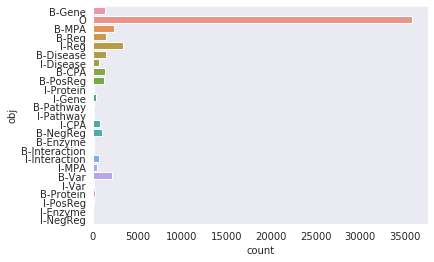

In [12]:
sns.countplot(y = "obj", data=data_df)

Frequency without label 'O'.

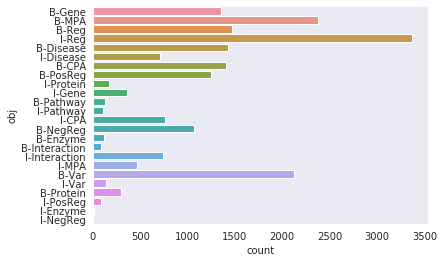

In [13]:
sns.countplot(y = "obj", data=data_df[data_df['obj'] != 'O'])

## Deep Learning - LSTM | PyTorch

### Create a list of words and output tags

In [26]:
words = list(set(data_df["word"].values))
words.insert(0, "PAD")
n_words = len(words)
print(f"Number of words = {n_words}")

Number of words = 9745


In [31]:
tags = list(set(data_df["obj"].values))
tags.insert(0, "PAD-TAG")
n_tags = len(tags)
print(f"Number of tags = {n_tags}")

Number of tags = 26


### Data Loader

In [33]:
class LoadData(Dataset):
    
    def __init__(self, data):
        self.data = data
        
        agg_func = lambda x: [(w, t) for w, t in zip(x['word'].values.tolist(), x['obj'].values.tolist())]
        
        self.grouped_data = self.data.groupby('doc_id').apply(agg_func)
        self.sentences = [x for x in self.grouped_data]
        
    def __getitem__(self, index):
        return self.sentences[index]
        
    def __len__ (self):
        return len(self.X_data)

    


class TrainData(Dataset):
    
    def __init__(self, X_data, y_data, maxlen):
        self.X_data = X_data
        self.y_data = y_data
        self.maxlen = maxlen
        
        
    def __getitem__(self, index):
        self.X_data[index] = self.pad_data(self.X_data[index])
        self.y_data[index] = self.pad_data(self.y_data[index])

        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
    def pad_data(self, s):
        padded = np.zeros((self.maxlen,), dtype=np.int64)
        
        if len(s) > self.maxlen:
            padded[:] = s[:self.maxlen]
        else: 
            padded[:len(s)] = s
        return padded

    
class TestData(Dataset):
    
    def __init__(self, X_data, y_data, maxlen):
        self.X_data = X_data
        self.y_data = y_data
        self.maxlen = maxlen
        
    def __getitem__(self, index):
        self.X_data[index] = self.pad_data(self.X_data[index])
        self.y_data[index] = self.pad_data(self.y_data[index])
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
    def pad_data(self, s):
        padded = np.zeros((self.maxlen,), dtype=np.int64)

        if len(s) > self.maxlen:
            padded[:] = s[:self.maxlen]
        else: 
            padded[:len(s)] = s
        return padded


In [34]:
loaded_data = LoadData(data_df)

### Extract Sentences

In [35]:
sentence_tag_list = loaded_data.sentences

### Number of words per sentence.

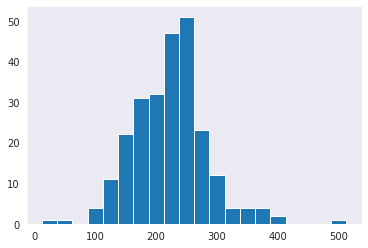

In [36]:
plt.hist([len(s) for s in sentence_tag_list], bins=20)
plt.show()

Majority of the sentences have 250 words per sentence. So, we'll set the limit for max words as 250. Each sentence will be padded or stripped down to maintain 250 words.

### Create word/tag to id dictionary.

In [37]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [38]:
print(f"ID for the word 'variations' in the dictionary is: {word2idx['variations']}")
print(f"ID for the tag 'O' in the dictionary is: {tag2idx['O']}")

ID for the word 'variations' in the dictionary is: 9359
ID for the tag 'O' in the dictionary is: 12


### Encode sentences.

In [39]:
X = [[word2idx[w[0]] for w in s] for s in sentence_tag_list]

### Encode tags.

In [40]:
y = [[tag2idx[w[1]] for w in s] for s in sentence_tag_list]

### Split data into train and test sets.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

### Define NN architecture.

In [42]:
EMBEDDING_SIZE = 128
HIDDEN_SIZE = 128
LEARNING_RATE = 0.01
EPOCHS = 100
STACKED_LAYERS = 2
SENTENCE_LEN = 256
BATCH_SIZE = 32

In [43]:
train_data = TrainData(X_train, y_train, maxlen = SENTENCE_LEN)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE)

test_data = TestData(X_test, y_test, maxlen = SENTENCE_LEN)
test_loader = DataLoader(test_data, batch_size=1)

In [44]:
class LSTMtagger(nn.Module):
    
    def __init__(self, embedding_size, vocab_size, hidden_size, target_size):
        super(LSTMtagger, self).__init__()
        
        self.word_embeddings = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embedding_size)
        self.lstm = nn.LSTM(input_size = embedding_size, hidden_size=hidden_size, batch_first = True, num_layers = STACKED_LAYERS)
        self.linear = nn.Linear(in_features = hidden_size, out_features=target_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)
        linear_out = self.linear(lstm_out)
        y_out = F.log_softmax(linear_out, dim=1)
        return y_out

In [45]:
tl = iter(train_loader)
i, j = next(tl)
print(i)
print(j)

tensor([[5095, 3689, 6166,  ...,    0,    0,    0],
        [8890, 4915, 6166,  ..., 7713, 6602, 2377],
        [5632, 5230, 1868,  ...,    0,    0,    0],
        ...,
        [9081, 4517, 6937,  ...,    0,    0,    0],
        [9457, 8600, 9669,  ...,    0,    0,    0],
        [8926, 2385, 4650,  ...,    0,    0,    0]])
tensor([[12, 19,  3,  ...,  0,  0,  0],
        [12, 12,  3,  ..., 12, 12, 12],
        [12, 12, 25,  ...,  0,  0,  0],
        ...,
        [12, 12,  4,  ...,  0,  0,  0],
        [10, 19, 13,  ...,  0,  0,  0],
        [12,  7, 12,  ...,  0,  0,  0]])


In [46]:
model = LSTMtagger(embedding_size=EMBEDDING_SIZE, vocab_size=len(word2idx), hidden_size=HIDDEN_SIZE, target_size=len(tag2idx))
print(model)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

LSTMtagger(
  (word_embeddings): Embedding(9745, 128)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=26, bias=True)
)


### Check out the output from the model

In [47]:
with torch.no_grad():
    for x_batch, y_batch in train_loader:
               
        print("Input:")
        print(x_batch)
        y_out = model(x_batch)
        _, y_out_tags = torch.max(y_out.squeeze(), dim = 1)
        
        print("\nOutput:")
        print(y_out, y_out.shape)
        
        print("\nOutput Indices:")
        print(y_out_tags)

        print("\nActual Output:")
        print(y_batch, y_batch.shape)
        
        print("=" * 50)
        
        break

Input:
tensor([[5095, 3689, 6166,  ...,    0,    0,    0],
        [8890, 4915, 6166,  ..., 7713, 6602, 2377],
        [5632, 5230, 1868,  ...,    0,    0,    0],
        ...,
        [9081, 4517, 6937,  ...,    0,    0,    0],
        [9457, 8600, 9669,  ...,    0,    0,    0],
        [8926, 2385, 4650,  ...,    0,    0,    0]])

Output:
tensor([[[-5.5349, -5.5229, -5.5350,  ..., -5.5392, -5.5754, -5.5580],
         [-5.5467, -5.5399, -5.5326,  ..., -5.5208, -5.5888, -5.5686],
         [-5.5487, -5.5467, -5.5169,  ..., -5.5105, -5.5857, -5.5684],
         ...,
         [-5.5469, -5.5360, -5.6453,  ..., -5.4855, -5.4728, -5.5232],
         [-5.5469, -5.5360, -5.6453,  ..., -5.4855, -5.4728, -5.5232],
         [-5.5469, -5.5360, -5.6453,  ..., -5.4855, -5.4728, -5.5232]],

        [[-5.5383, -5.5339, -5.5654,  ..., -5.5391, -5.5481, -5.5388],
         [-5.5563, -5.5391, -5.5476,  ..., -5.5474, -5.5458, -5.5366],
         [-5.5565, -5.5337, -5.5290,  ..., -5.5372, -5.5430, -5.5449],
   

### Train the model.

In [48]:
PRINT_EVERY = int(len(X_train)/BATCH_SIZE) + 1
PRINT_EVERY

8

In [50]:
print("Training Started.")
loss_list = []
for e in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    
#     for x_batch, y_batch in train_loader:
    for i, data in enumerate(train_loader):    
        x_batch, y_batch = data
        
        model.zero_grad()
        
        y_pred = model(x_batch)
        y_batch = y_batch.view(-1)
        y_pred = y_pred.view(-1, len(tag2idx))

        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        
        _, y_pred_tags = torch.max(y_pred.squeeze(), dim = 1)
        
        running_loss += loss.item()
        
        
        if (i % PRINT_EVERY == 0):
            loss_list.append(running_loss/PRINT_EVERY)
            print(f'Epoch {e}/{EPOCHS} : loss = {running_loss/PRINT_EVERY}')
        
print("Training Completed.")

Training Started.
Epoch 1/100 : loss = 0.6201258897781372
Epoch 2/100 : loss = 0.5769319534301758
Epoch 3/100 : loss = 0.5446072816848755
Epoch 4/100 : loss = 0.5244742035865784
Epoch 5/100 : loss = 0.512213945388794
Epoch 6/100 : loss = 0.5052508115768433
Epoch 7/100 : loss = 0.5013416409492493
Epoch 8/100 : loss = 0.4992583990097046
Epoch 9/100 : loss = 0.4981771409511566
Epoch 10/100 : loss = 0.49708494544029236
Epoch 11/100 : loss = 0.4965776801109314
Epoch 12/100 : loss = 0.4962022304534912
Epoch 13/100 : loss = 0.49597039818763733
Epoch 14/100 : loss = 0.49588194489479065
Epoch 15/100 : loss = 0.4956291615962982
Epoch 16/100 : loss = 0.49540871381759644
Epoch 17/100 : loss = 0.49540847539901733
Epoch 18/100 : loss = 0.49528491497039795
Epoch 19/100 : loss = 0.49522989988327026
Epoch 20/100 : loss = 0.4952215850353241
Epoch 21/100 : loss = 0.49516332149505615
Epoch 22/100 : loss = 0.4951440691947937
Epoch 23/100 : loss = 0.4951411783695221
Epoch 24/100 : loss = 0.49510860443115234

### Train Acc and Val Acc.

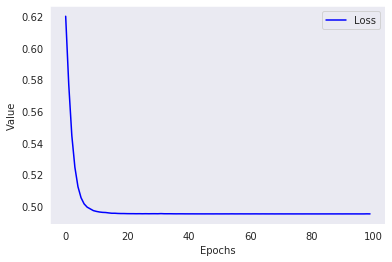

In [51]:
import matplotlib.pyplot as plt

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()


### Classification Metrics.

In [52]:
y_out_tags_list = []
with torch.no_grad():
    for x_batch, y_batch in test_loader: 
        y_out = model(x_batch)
        _, y_out_tags = torch.max(y_out.squeeze(), dim = 1)
        y_out_tags = np.array(y_out_tags)
        y_out_tags_list.append(y_out_tags)
        
        
print(metrics.flat_classification_report(y_test, y_out_tags_list))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1215
           1       0.46      0.82      0.59        40
           2       0.00      0.00      0.00         0
           3       1.00      0.99      0.99       331
           4       1.00      1.00      1.00        79
           5       0.00      0.00      0.00         0
           6       0.81      0.77      0.79        73
           7       1.00      0.97      0.99       115
           8       0.36      0.77      0.49        13
           9       0.84      0.93      0.88        56
          10       0.34      0.27      0.30       101
          11       0.04      0.71      0.08         7
          12       0.97      0.85      0.91      3285
          13       1.00      0.97      0.99       138
          14       0.39      1.00      0.56        14
          15       0.85      0.69      0.76       183
          16       0.33      0.85      0.47        26
          17       0.03    

/home/akshaj/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/akshaj/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/akshaj/anaconda3/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Try out the model

In [53]:
testl = iter(test_loader)

In [54]:
with torch.no_grad():
    x_batch, y_batch = next(testl)
    y_pred = model(x_batch)
    
    _, y_pred = torch.max(y_pred.squeeze(), 1)
    x_batch = x_batch.squeeze()
    y_batch = y_batch.squeeze()
    
    print('{:26}: {:15}: {}\n'.format("Word", "Pred", "Actual"))
    
    for w, pred, actual in zip(x_batch, y_pred, y_batch):
        pprint("{:25}: {:15}: {}".format(words[w.item()], tags[pred], tags[actual.item()]))

Word                      : Pred           : Actual

'Multiple                 : O              : O'
'Legionella               : I-Enzyme       : O'
'pneumophila              : I-Pathway      : I-CPA'
'effector                 : I-Pathway      : O'
'virulence                : B-MPA          : B-MPA'
'phenotypes               : I-Pathway      : O'
'revealed                 : B-Reg          : B-Reg'
'through                  : O              : O'
'high-throughput          : O              : O'
'analysis                 : O              : O'
'of                       : O              : O'
'targeted                 : O              : O'
'mutant                   : B-Var          : B-Var'
'libraries                : O              : O'
'Legionella               : I-Enzyme       : O'
'pneumophila              : I-Pathway      : I-CPA'
'is                       : O              : O'
'the                      : O              : O'
'causative                : O              : O'
'agent         